In [0]:
import sys
if 'google.colab' in sys.modules: # Colab-only Tensorflow version selector
  %tensorflow_version 2.x

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

TensorFlow 2.x selected.
Tensorflow version 2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Scripts/.' .

In [0]:
MODEL_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/'
MODEL_NAME = '138-BERT_base_uncased'

## Dependencies

In [0]:
import glob
import warnings
from tensorflow_hub import KerasLayer
from tensorflow.keras import Model, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, SpatialDropout1D, Concatenate
from googleqa_utilityscript import *
from googleqa_map_utilityscript import *
from script_lr_schedulers import WarmUpLearningRateScheduler
import bert_tokenization as tokenization


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [0]:
BERT_PATH = '/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Modules/bert_base_uncased'
VOCAB_PATH = BERT_PATH + '/assets/vocab.txt'

k_fold = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Data/5-fold.csv')
N_FOLDS = 5

print('Samples: %s' % len(k_fold))
display(k_fold.head())

Samples: 6079


,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000,train,train,train,validation,train
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889,validation,train,train,train,train
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889,train,train,validation,train,train
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000,train,train,train,train,validation
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000,validation,train,train,train,train


In [0]:
question_target_cols = ['question_asker_intent_understanding','question_body_critical', 'question_conversational', 
                        'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer',
                        'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 
                        'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice',
                        'question_type_compare', 'question_type_consequence', 'question_type_definition', 
                        'question_type_entity', 'question_type_instructions', 'question_type_procedure',
                        'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']
answer_target_cols = ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance',
                      'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 
                      'answer_type_reason_explanation', 'answer_well_written']
target_cols = question_target_cols + answer_target_cols

In [0]:
### BERT auxiliar function
def _get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def _get_segments(tokens, max_seq_length, ignore_first_sep=True):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            if ignore_first_sep:
                ignore_first_sep = False 
            else:
                current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def _get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

def _trim_input(title, question, answer, tokenizer, max_sequence_length, 
                t_max_len=30, q_max_len=239, a_max_len=239):
    
    t = tokenizer.tokenize(title)
    q = tokenizer.tokenize(question)
    a = tokenizer.tokenize(answer)
    
    t_len = len(t)
    q_len = len(q)
    a_len = len(a)

    if (t_len+q_len+a_len+4) > max_sequence_length:
        
        if t_max_len > t_len:
            t_new_len = t_len
            a_max_len = a_max_len + floor((t_max_len - t_len)/2)
            q_max_len = q_max_len + ceil((t_max_len - t_len)/2)
        else:
            t_new_len = t_max_len
      
        if a_max_len > a_len:
            a_new_len = a_len 
            q_new_len = q_max_len + (a_max_len - a_len)
        elif q_max_len > q_len:
            a_new_len = a_max_len + (q_max_len - q_len)
            q_new_len = q_len
        else:
            a_new_len = a_max_len
            q_new_len = q_max_len
            
            
        if t_new_len+a_new_len+q_new_len+4 != max_sequence_length:
            raise ValueError("New sequence length should be %d, but is %d" 
                             % (max_sequence_length, (t_new_len+a_new_len+q_new_len+4)))
            

        t = t[:t_new_len//2] + t[-t_new_len//2:]
        q = q[:q_new_len//2] + q[-q_new_len//2:]
        a = a[:a_new_len//2] + a[-a_new_len//2:]

    return t, q, a

def _convert_to_bert_inputs(title, question, answer, tokenizer, max_sequence_length, ignore_first_sep=True):
    """Converts tokenized input to ids, masks and segments for BERT"""
    
    stoken = ["[CLS]"] + title + ["[SEP]"] + question + ["[SEP]"] + answer + ["[SEP]"]

    input_ids = _get_ids(stoken, tokenizer, max_sequence_length)
    input_masks = _get_masks(stoken, max_sequence_length)
    input_segments = _get_segments(stoken, max_sequence_length, ignore_first_sep)

    return [input_ids, input_masks, input_segments]

def compute_input_arays(df, columns, tokenizer, max_sequence_length, ignore_first_sep=True):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in df[columns].iterrows():
        t, q, a = instance.question_title, instance.question_body, instance.answer

        t, q, a = _trim_input(t, q, a, tokenizer, max_sequence_length)

        ids, masks, segments = _convert_to_bert_inputs(t, q, a, tokenizer, max_sequence_length, ignore_first_sep)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

# Pre-process data

In [0]:
text_features = ['question_title', 'question_body', 'answer']

# for feature in text_features:
#     # Lower
#     k_fold[feature] = k_fold[feature].apply(lambda x: x.lower())
#     # Map misspellings
#     k_fold[feature] = k_fold[feature].apply(lambda x: map_misspellings(x))
#     # Map contractions
#     k_fold[feature] = k_fold[feature].apply(lambda x: map_contraction(x))
#     # Trim text
#     k_fold[feature] = k_fold[feature].apply(lambda x: x.strip())

# Model parameters

In [0]:
EPOCHS = 8
BATCH_SIZE = 8
LEARNING_RATE = 3e-5
N_CLASS = len(target_cols)
ES_PATIENCE = 1
MAX_SEQUENCE_LENGTH = 512
LR_WARMUP_EPOCHS = 2

# Model

In [0]:
def model_fn():
    input_word_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_word_ids')
    input_masks = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
    segment_ids = Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='segment_ids')

    bert_layer = KerasLayer(BERT_PATH, trainable=True)
    pooled_output, sequence_output = bert_layer([input_word_ids, input_masks, segment_ids])

    x = GlobalAveragePooling1D()(sequence_output)
    x = Dropout(0.2)(x)
    output = Dense(N_CLASS, activation="sigmoid", name="output")(x)

    model = Model(inputs=[input_word_ids, input_masks, segment_ids], outputs=output)
    
    return model

# Train model

In [12]:
tokenizer = tokenization.FullTokenizer(VOCAB_PATH, True)

history_list = []
metric_list = []
category_metric_list = []
target_cols_preds = [col+'_pred' for col in target_cols]

for n_fold in range(N_FOLDS):
    ### Data
    train = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation']
    
    ### Create features
    # Train features
    X_train = compute_input_arays(train, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
    Y_train = train[target_cols].values

    # Validation features
    X_valid = compute_input_arays(validation, text_features, tokenizer, MAX_SEQUENCE_LENGTH)
    Y_valid = validation[target_cols].values

    # Train model
    model_path = MODEL_BASE_PATH + MODEL_NAME + '_model_fold_%d' % (n_fold+1)
    spearmanCallback = SpearmanRhoCallback(training_data=(X_train, Y_train), 
                                           validation_data=(X_valid, Y_valid), 
                                           model_path=model_path, 
                                           monitor='val_loss', mode='min', 
                                           patience=ES_PATIENCE, checkpoint=True)
    WARMUP_BATCHES = LR_WARMUP_EPOCHS * len(train) // BATCH_SIZE
    warmup_lr = WarmUpLearningRateScheduler(WARMUP_BATCHES, LEARNING_RATE)

    callback_list = [spearmanCallback, warmup_lr]
    optimizer = optimizers.Adam(lr=LEARNING_RATE)
    model = model_fn()
    model.compile(optimizer=optimizer, loss='binary_crossentropy')

    history = model.fit(X_train, Y_train, 
                        validation_data=(X_valid, Y_valid), 
                        callbacks=callback_list, 
                        batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, 
                        verbose=2).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights(MODEL_BASE_PATH + MODEL_NAME + '_model_fold_%d_last_epoch.h5' % (n_fold+1))
    
    ### Evaluation - Label metrics
    model.load_weights(model_path+'.h5')
    preds_train = model.predict(X_train)
    preds_val = model.predict(X_valid)
    metric_list.append(get_metrics(Y_train, preds_train, Y_valid, preds_val, target_cols))
    
    ### Evaluation - Category metrics
    for col in target_cols_preds:
        train[col] = 0
        validation[col] = 0

    train[target_cols_preds] = preds_train
    validation[target_cols_preds] = preds_val
    category_metric_list.append(get_metrics_category(train, validation, target_cols, target_cols_preds, 'category'))

Train on 4864 samples, validate on 1215 samples
Epoch 1/8
spearman-rho: 0.3200 val_spearman-rho: 0.3020
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/138-BERT_base_uncased_model_fold_1.h5"
4864/4864 - 1005s - loss: 0.4575 - val_loss: 0.3889
Epoch 2/8
spearman-rho: 0.4197 val_spearman-rho: 0.3736
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/138-BERT_base_uncased_model_fold_1.h5"
4864/4864 - 995s - loss: 0.3852 - val_loss: 0.3715
Epoch 3/8
spearman-rho: 0.4812 val_spearman-rho: 0.3912
Saved model weights at "/content/drive/My Drive/Colab Notebooks/Google QUEST Q&A Labeling/Model backlog/Files/138-BERT_base_uncased_model_fold_1.h5"
4864/4864 - 995s - loss: 0.3661 - val_loss: 0.3667
Epoch 4/8
spearman-rho: 0.5380 val_spearman-rho: 0.3860
Epoch 00003: early stopping
4864/4864 - 995s - loss: 0.3487 - val_loss: 0.3710
Train on 4864 samples, validate on 1215 samples


## Model loss graph

Fold: 0


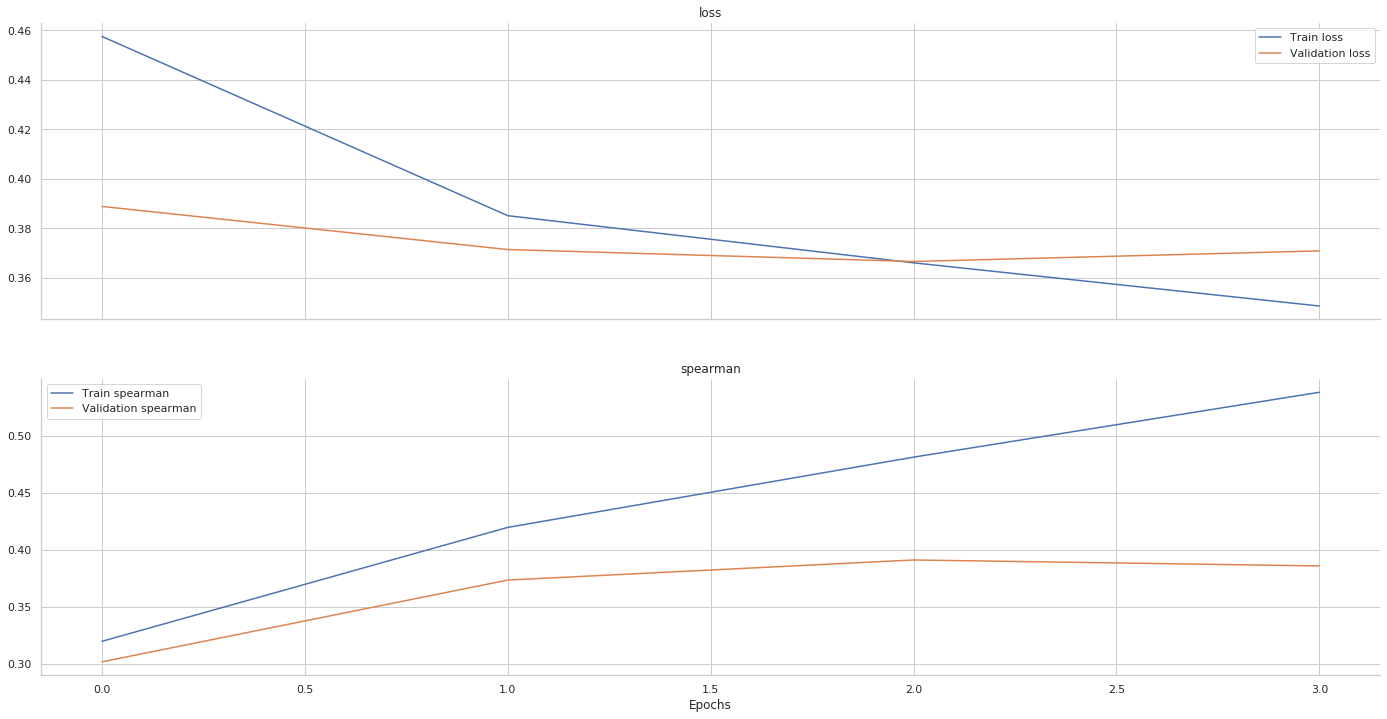

Fold: 1


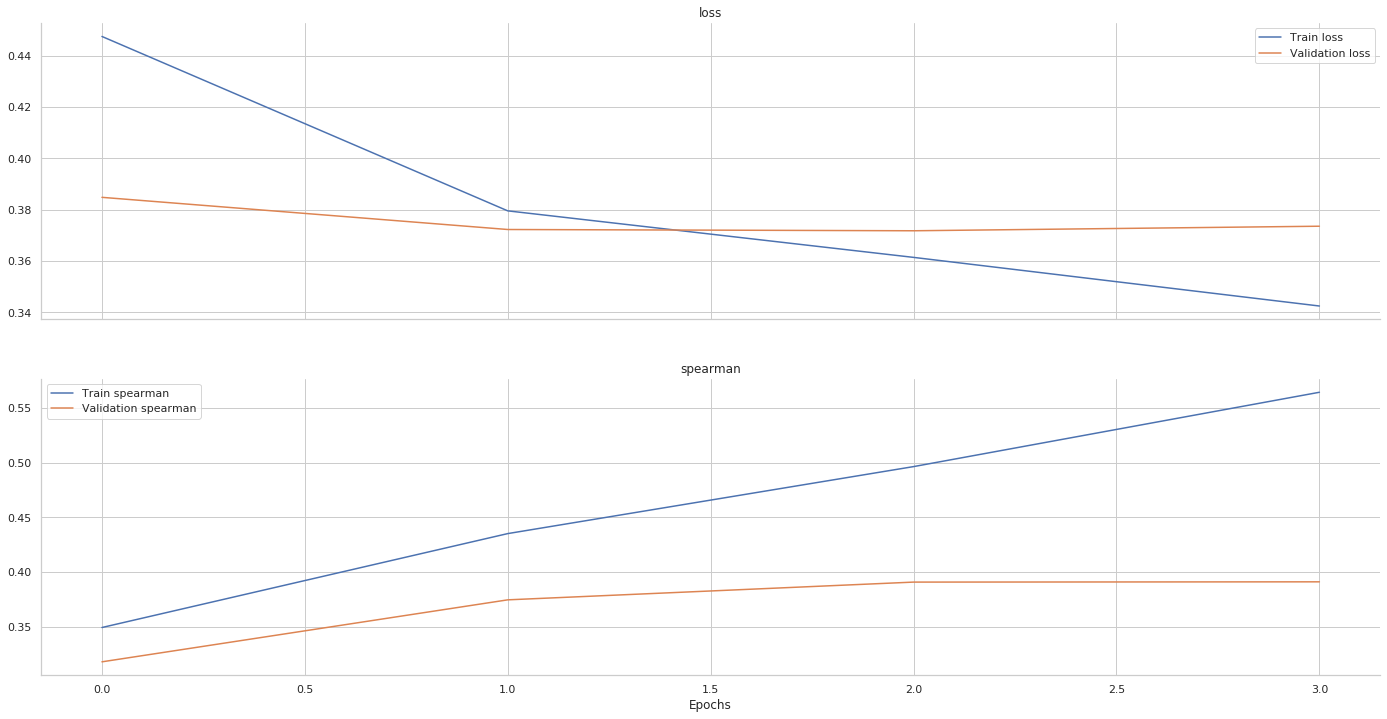

Fold: 2


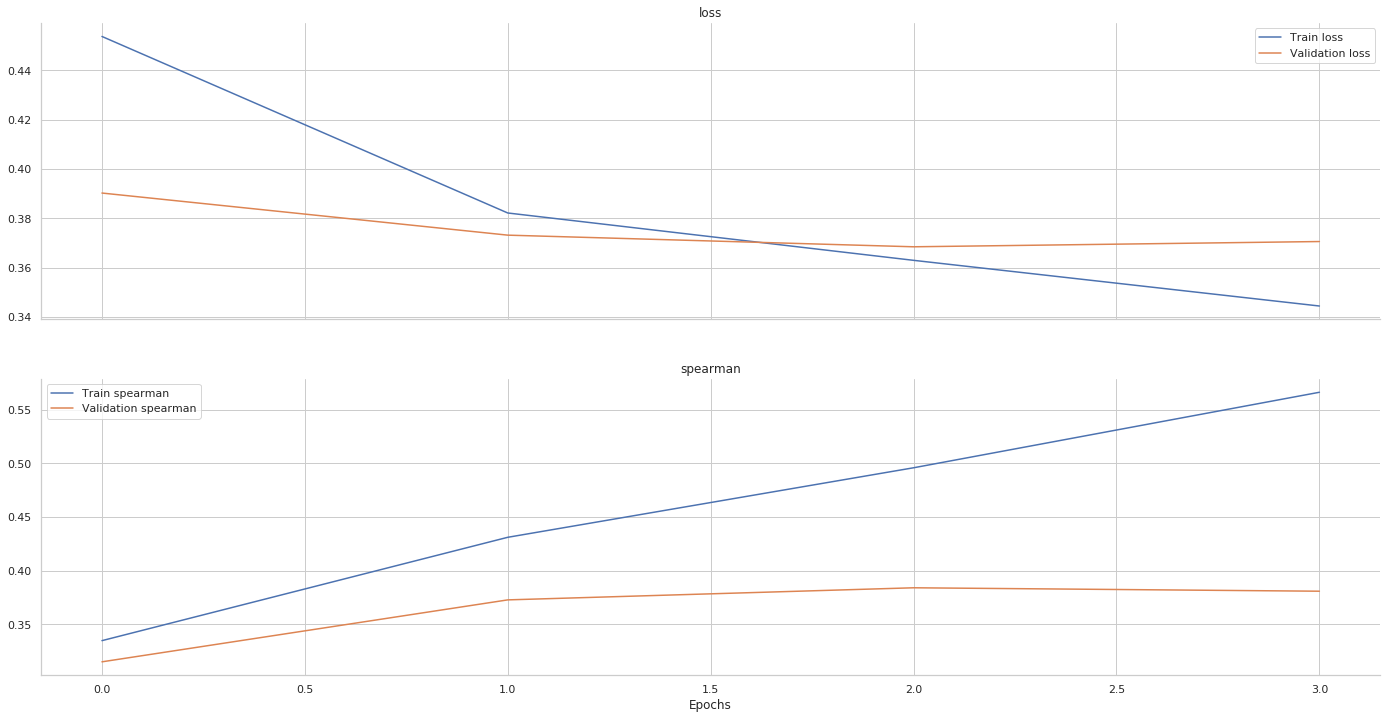

Fold: 3


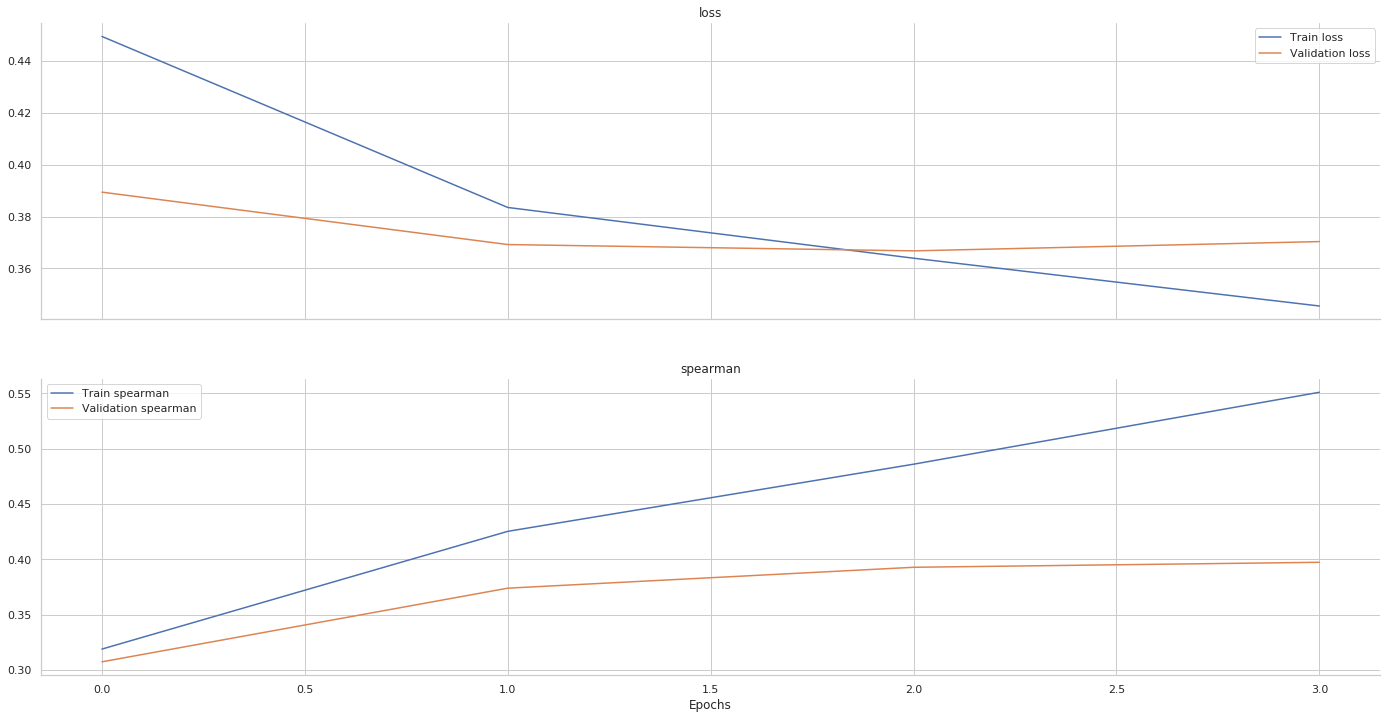

Fold: 4


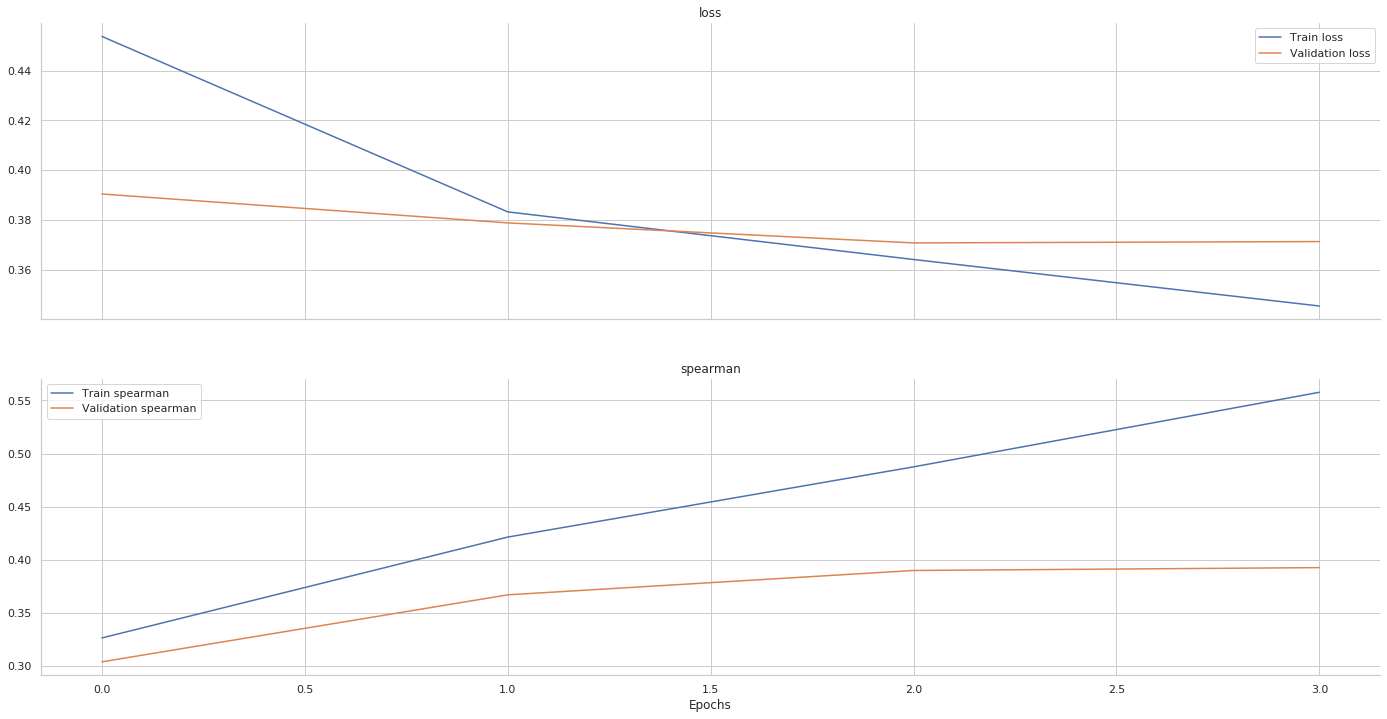

In [13]:
for n_fold in range(N_FOLDS):
    print('Fold: %d' % n_fold)
    sns.set(style="whitegrid")
    plot_metrics(history_list[n_fold], metric_list=['loss', 'spearman'])

# Evaluation

In [14]:
metrics_df = metric_list[0][['Label', 'Train', 'Validation']].copy()
metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    metrics_df_idx = metric_list[n_fold][['Train', 'Validation']].copy()
    metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    metrics_df = pd.concat([metrics_df, metrics_df_idx], axis=1)

metrics_df['Train'] = 0
metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    metrics_df['Train'] += metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    metrics_df['Validation'] += metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS

metrics_df['Var'] = metrics_df['Train'] - metrics_df['Validation']
display(metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train,Validation,Var
0,Averaged,0.481,0.391,0.496,0.391,0.496,0.384,0.486,0.393,0.487,0.39,0.4892,0.3898,0.0994
1,Question averaged,0.502,0.416,0.513,0.419,0.513,0.41,0.506,0.427,0.51,0.414,0.5088,0.4172,0.0916
2,Answer averaged,0.433,0.333,0.457,0.325,0.456,0.324,0.441,0.313,0.434,0.332,0.4442,0.3254,0.1188
3,question_asker_intent_understanding,0.428,0.36,0.452,0.37,0.478,0.305,0.455,0.387,0.457,0.366,0.454,0.3576,0.0964
4,question_body_critical,0.675,0.58,0.673,0.619,0.672,0.587,0.679,0.606,0.68,0.587,0.6758,0.5958,0.08
5,question_conversational,0.459,0.411,0.461,0.387,0.464,0.423,0.461,0.423,0.466,0.404,0.4622,0.4096,0.0526
6,question_expect_short_answer,0.459,0.325,0.507,0.261,0.518,0.249,0.492,0.345,0.475,0.274,0.4902,0.2908,0.1994
7,question_fact_seeking,0.518,0.381,0.562,0.351,0.506,0.367,0.539,0.353,0.54,0.331,0.533,0.3566,0.1764
8,question_has_commonly_accepted_answer,0.561,0.453,0.568,0.423,0.59,0.422,0.56,0.47,0.577,0.418,0.5712,0.4372,0.134
9,question_interestingness_others,0.412,0.34,0.437,0.356,0.419,0.301,0.34,0.243,0.424,0.326,0.4064,0.3132,0.0932


## By category

In [15]:
category_metrics_df = category_metric_list[0][['Label', 'Train', 'Validation']].copy()
category_metrics_df.columns = ['Label', 'Train_fold_0', 'Valid_fold_0']

for n_fold in range(1, N_FOLDS):
    category_metrics_df_idx = category_metric_list[n_fold][['Train', 'Validation']].copy()
    category_metrics_df_idx.columns = ['Train_fold_%d' % n_fold, 'Valid_fold_%d' % n_fold]
    category_metrics_df = pd.concat([category_metrics_df, category_metrics_df_idx], axis=1)
    
category_metrics_df['Train'] = 0
category_metrics_df['Validation'] = 0
for n_fold in range(N_FOLDS):
    category_metrics_df['Train'] += category_metrics_df['Train_fold_%d' % n_fold] / N_FOLDS
    category_metrics_df['Validation'] += category_metrics_df['Valid_fold_%d' % n_fold] / N_FOLDS
    
category_metrics_df['Var'] = category_metrics_df['Train'] - category_metrics_df['Validation']
display(category_metrics_df.style.applymap(color_map))

,Label,Train_fold_0,Valid_fold_0,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train,Validation,Var
0,LIFE_ARTS,0.516,0.414,0.539,0.412,0.528,0.428,0.521,0.383,0.523,0.403,0.5254,0.408,0.1174
1,SCIENCE,0.502,0.405,0.539,0.356,0.528,0.385,0.508,0.396,0.529,0.374,0.5212,0.3832,0.138
2,CULTURE,0.518,0.407,0.508,0.389,0.463,0.347,0.522,0.416,0.506,0.442,0.5034,0.4002,0.1032
3,STACKOVERFLOW,0.357,0.267,0.384,0.278,0.514,0.374,0.374,0.274,0.375,0.246,0.4008,0.2878,0.113
4,TECHNOLOGY,0.444,0.342,0.462,0.364,0.389,0.254,0.454,0.356,0.456,0.346,0.441,0.3324,0.1086
